In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from src.utils import get_weeks, week_num
week_labels = get_weeks(day_from=20160104, num_weeks=121)[91:]

In [4]:
print(week_labels)

[20171002, 20171009, 20171016, 20171023, 20171030, 20171106, 20171113, 20171120, 20171127, 20171204, 20171211, 20171218, 20171225, 20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [5]:
%%time
train = pd.DataFrame()
for name in week_labels[13:-2]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])

CPU times: user 1min 26s, sys: 46.6 s, total: 2min 12s
Wall time: 2min 23s


In [6]:
%%time
val = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-2]}_SVD_diffscount.feather')
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

CPU times: user 572 ms, sys: 380 ms, total: 952 ms
Wall time: 951 ms


## End checkpoint

In [7]:
from src.structurednet import get_seqs, shift_right

In [8]:
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)

In [9]:
%%time
transactions = get_seqs(trade, challenge, week_labels, 
                        ['CustomerIdx', 'IsinIdx', 'BuySell'])
buysells = get_seqs(trade, challenge, week_labels, 
                        ['CustomerIdx', 'IsinIdx'])
customers = get_seqs(trade, challenge, week_labels, ['CustomerIdx'])
isins = get_seqs(trade, challenge, week_labels, ['IsinIdx'])

CPU times: user 13.2 s, sys: 636 ms, total: 13.8 s
Wall time: 13.8 s


In [10]:
for c in ['CustomerIdx', 'IsinIdx', 'BuySell', 'CompositeRating']:
    train[f'{c}Cat'] = train[c]
    val[f'{c}Cat'] = val[c]
    test[f'{c}Cat'] = test[c]

In [11]:
train['BuySellCont'] = train.BuySell.apply(lambda x: int(x == 'Buy'))
val['BuySellCont'] = val.BuySell.apply(lambda x: int(x == 'Buy'))
test['BuySellCont'] = test.BuySell.apply(lambda x: int(x == 'Buy'))

In [12]:
train['Week'] = train.TradeDateKey.apply(lambda x: week_num(week_labels, x))
val['Week'] = val.TradeDateKey.apply(lambda x: week_num(week_labels, x))
test['Week'] = test.TradeDateKey.apply(lambda x: week_num(week_labels, x))

In [13]:
cat_cols = ['Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType',
            'CompositeRatingCat', 'CustomerIdxCat', 'IsinIdxCat', 'BuySellCat']
num_cols = ['ActualMaturityDateKey', 'IssueDateKey', 'IssuedAmount', 
            'BondDuration', 'BondRemaining', 'BondLife', 
            'Day', 'CompositeRating', 'BuySellCont',
            
            'DaysSinceBuySell', 'DaysSinceTransaction', 'DaysSinceCustomerActivity',
            'DaysSinceBondActivity', 'DaysCountBuySell', 'DaysCountTransaction',
            'DaysCountCustomerActivity', 'DaysCountBondActivity', 'SVD_CustomerBias',
            'SVD_IsinBuySellBias', 'SVD_Recommend', 'SVD_CustomerFactor00',
            'SVD_CustomerFactor01', 'SVD_CustomerFactor02', 'SVD_CustomerFactor03',
            'SVD_CustomerFactor04', 'SVD_CustomerFactor05', 'SVD_CustomerFactor06',
            'SVD_CustomerFactor07', 'SVD_CustomerFactor08', 'SVD_CustomerFactor09',
            'SVD_CustomerFactor10', 'SVD_CustomerFactor11', 'SVD_CustomerFactor12',
            'SVD_CustomerFactor13', 'SVD_CustomerFactor14']
id_cols = ['CustomerIdx', 'IsinIdx', 'BuySell']
target_col = 'CustomerInterest'

In [14]:
%%time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pd.concat([train[num_cols], 
                            val[num_cols], test[num_cols]]))

CPU times: user 10 s, sys: 8.88 s, total: 18.9 s
Wall time: 18.9 s


In [15]:
NEURALNET = INTERIM/'neuralnet'

In [16]:
%%time
train.reset_index(drop=True).to_feather(NEURALNET/'train.feather')
val.reset_index(drop=True).to_feather(NEURALNET/'val.feather')
test.reset_index(drop=True).to_feather(NEURALNET/'test.feather')

In [20]:
%%time
from src.structurednet import extract_seqs
n_weeks = len(week_labels)
train_seqs = extract_seqs(train, transactions, buysells, 
                              customers, isins, n_weeks)

HBox(children=(IntProgress(value=0, max=8102750), HTML(value='')))


CPU times: user 10min 56s, sys: 2min 44s, total: 13min 40s
Wall time: 10min 49s


In [21]:
%%time
val_seqs = extract_seqs(val, transactions, buysells, 
                              customers, isins, n_weeks)
test_seqs = extract_seqs(test, transactions, buysells, 
                              customers, isins, n_weeks)

HBox(children=(IntProgress(value=0, max=493590), HTML(value='')))

HBox(children=(IntProgress(value=0, max=484758), HTML(value='')))


CPU times: user 1min 15s, sys: 19 s, total: 1min 34s
Wall time: 1min 13s


In [22]:
%%time
import pickle
with open(NEURALNET/'train_seqs.pkl', 'wb') as f:
    pickle.dump(train_seqs, f, pickle.HIGHEST_PROTOCOL)
with open(NEURALNET/'val_seqs.pkl', 'wb') as f:
    pickle.dump(val_seqs, f, pickle.HIGHEST_PROTOCOL)
with open(NEURALNET/'test_seqs.pkl', 'wb') as f:
    pickle.dump(test_seqs, f, pickle.HIGHEST_PROTOCOL)

In [23]:
with open(NEURALNET/'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f, pickle.HIGHEST_PROTOCOL)

In [25]:
%%time
from src.structurednet import preprocess_catsconts
preprocess_catsconts(train, val, test, cat_cols, num_cols, scaler)

Encoding cats...
Scaling conts...
CPU times: user 34.5 s, sys: 964 ms, total: 35.5 s
Wall time: 35.6 s


In [27]:
%%time
train.reset_index(drop=True).to_feather(NEURALNET/'train_preproc.feather')
val.reset_index(drop=True).to_feather(NEURALNET/'val_preproc.feather')
test.reset_index(drop=True).to_feather(NEURALNET/'test_preproc.feather')

CPU times: user 5.36 s, sys: 6 s, total: 11.4 s
Wall time: 9.53 s


## Model

In [72]:
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from src.structured_lstm import MultimodalDataset, MultimodalNet, train_model

In [29]:
train_seqs.shape

(8102750, 4, 29)

In [90]:
%%time
train_dl = DataLoader(MultimodalDataset(
                train[cat_cols], train[num_cols],
                train_seqs, train[target_col]),
                batch_size=128, shuffle=True)
val_dl = DataLoader(MultimodalDataset(
                val[cat_cols], val[num_cols],
                val_seqs, val[target_col]), 
                batch_size=128)

CPU times: user 2.88 s, sys: 3.34 s, total: 6.22 s
Wall time: 6.21 s


In [31]:
cat_szs = [int(train[col].max() + 1) for col in cat_cols]
emb_szs = [(c, min(50, (c+1)//2)) for c in cat_szs]

In [33]:
emb_szs

[(5, 3),
 (36, 18),
 (3, 2),
 (86, 43),
 (3240, 50),
 (9, 5),
 (21, 11),
 (3, 2),
 (8, 4),
 (15, 8),
 (37, 19),
 (101, 50),
 (14, 7),
 (330, 50),
 (15, 8),
 (6, 3),
 (29, 15),
 (2594, 50),
 (22989, 50),
 (2, 1)]

## Validation

In [91]:
USE_CUDA = True

In [92]:
model = MultimodalNet(emb_szs, n_cont=len(num_cols), emb_drop=0.1,
                      szs=[1000,500], drops=[0.3, 0.3],
                      rnn_hidden_sz=128, rnn_input_sz=4, rnn_n_layers=2,
                      rnn_drop=0.2)

if USE_CUDA: model = model.cuda()

In [58]:
%%time
model, train_losses, val_losses, val_auc_scores = train_model(
                model, train_dl, val_dl, optimizer, criterion,
                n_epochs=2, USE_CUDA=USE_CUDA, val_every=20)

Train Epoch: 1 [25600/8102750 (0%)]	Loss: 0.174815
Train Epoch: 1 [51200/8102750 (1%)]	Loss: 0.134851
Train Epoch: 1 [76800/8102750 (1%)]	Loss: 0.134749
Train Epoch: 1 [102400/8102750 (1%)]	Loss: 0.134110
Train Epoch: 1 [128000/8102750 (2%)]	Loss: 0.132347
Train Epoch: 1 [153600/8102750 (2%)]	Loss: 0.136552
Train Epoch: 1 [179200/8102750 (2%)]	Loss: 0.130818
Train Epoch: 1 [204800/8102750 (3%)]	Loss: 0.130721
Train Epoch: 1 [230400/8102750 (3%)]	Loss: 0.133113
Train Epoch: 1 [256000/8102750 (3%)]	Loss: 0.134017
Train Epoch: 1 [281600/8102750 (3%)]	Loss: 0.131956
Train Epoch: 1 [307200/8102750 (4%)]	Loss: 0.128131
Train Epoch: 1 [332800/8102750 (4%)]	Loss: 0.129957
Train Epoch: 1 [358400/8102750 (4%)]	Loss: 0.130897
Train Epoch: 1 [384000/8102750 (5%)]	Loss: 0.130943
Train Epoch: 1 [409600/8102750 (5%)]	Loss: 0.132290
Train Epoch: 1 [435200/8102750 (5%)]	Loss: 0.126512
Train Epoch: 1 [460800/8102750 (6%)]	Loss: 0.130431
Train Epoch: 1 [486400/8102750 (6%)]	Loss: 0.131785
Train Epoch: 1 

In [60]:
train_losses = pd.Series(train_losses)
val_losses = pd.Series(val_losses)
val_auc_scores = pd.Series(val_auc_scores)

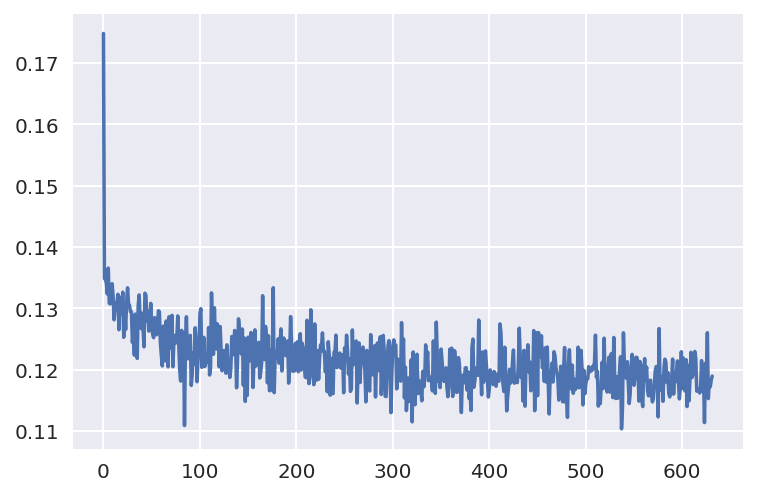

In [61]:
train_losses.plot()

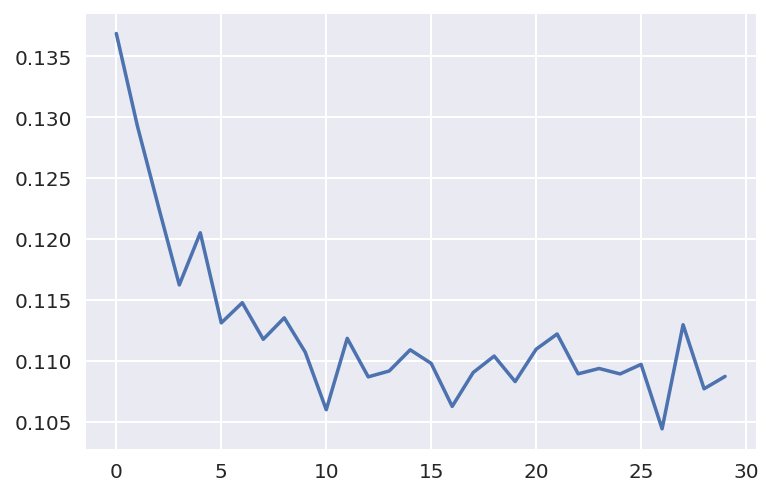

In [62]:
val_losses.plot()

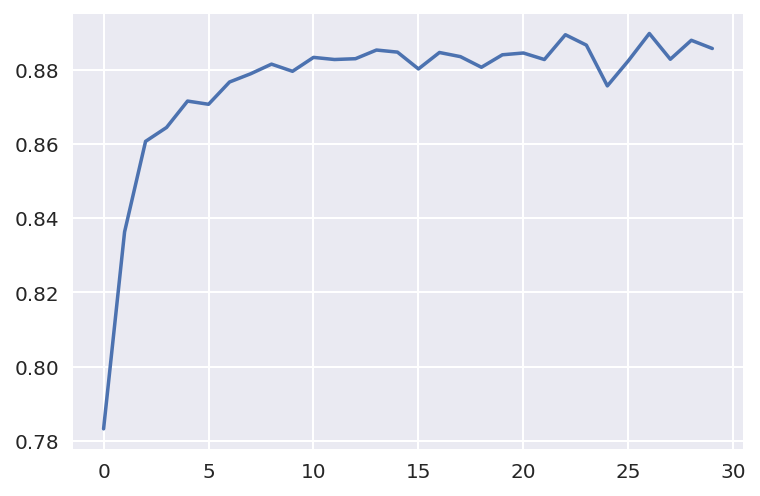

In [63]:
val_auc_scores.plot()

In [65]:
import torch
torch.save(model.state_dict(), NEURALNET/'StructuredNet.pkl')

In [ ]:
# Train ROC AUC Score: 0.821242
# Train Loss: 0.117414
# Validation ROC AUC Score: 0.888768
# Validation Loss: 0.107100
    
# Train ROC AUC Score: 0.826491
# Train Loss: 0.116814
# Validation ROC AUC Score: 0.881994
# Validation Loss: 0.109986

In [ ]:
# Train ROC AUC Score: 0.796762
# Train Loss: 0.119966
# Validation ROC AUC Score: 0.874341
# Validation Loss: 0.111939

# Train ROC AUC Score: 0.796169
# Train Loss: 0.119166
# Validation ROC AUC Score: 0.875377
# Validation Loss: 0.111252

In [ ]:
# Train ROC AUC Score: 0.792860
# Train Loss: 0.121061
# Validation ROC AUC Score: 0.872865
# Validation Loss: 0.117293
    
# Train ROC AUC Score: 0.794502
# Train Loss: 0.119734
# Validation ROC AUC Score: 0.875042
# Validation Loss: 0.112174

## Test (All train)

In [95]:
%%time
train_ds = MultimodalDataset(train[cat_cols], train[num_cols],
                             train_seqs, train[target_col])
val_ds = MultimodalDataset(val[cat_cols], val[num_cols],
                             val_seqs, val[target_col])
test_ds = MultimodalDataset(test[cat_cols], test[num_cols],
                             test_seqs, test[target_col])

CPU times: user 3.33 s, sys: 4.24 s, total: 7.57 s
Wall time: 7.57 s


In [96]:
all_train_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])

In [97]:
%%time
all_train_dl = DataLoader(all_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128)

CPU times: user 0 ns, sys: 212 ms, total: 212 ms
Wall time: 209 ms


In [98]:
USE_CUDA = True

In [99]:
model = MultimodalNet(emb_szs, n_cont=len(num_cols), emb_drop=0.2,
                      szs=[1000,500], drops=[0.5, 0.5],
                      rnn_hidden_sz=64, rnn_input_sz=4, rnn_n_layers=2,
                      rnn_drop=0.5)

if USE_CUDA: model = model.cuda()

In [104]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [105]:
%%time
model, train_losses, _, _ = train_model(
                model, all_train_dl, None, optimizer, criterion,
                n_epochs=2, USE_CUDA=USE_CUDA, print_every=800)

Train Epoch: 1 [102400/8596340 (1%)]	Loss: 0.149132
Train Epoch: 1 [204800/8596340 (2%)]	Loss: 0.134040
Train Epoch: 1 [307200/8596340 (4%)]	Loss: 0.132966
Train Epoch: 1 [409600/8596340 (5%)]	Loss: 0.131704
Train Epoch: 1 [512000/8596340 (6%)]	Loss: 0.132058
Train Epoch: 1 [614400/8596340 (7%)]	Loss: 0.126562
Train Epoch: 1 [716800/8596340 (8%)]	Loss: 0.128623
Train Epoch: 1 [819200/8596340 (10%)]	Loss: 0.129845
Train Epoch: 1 [921600/8596340 (11%)]	Loss: 0.126468
Train Epoch: 1 [1024000/8596340 (12%)]	Loss: 0.124746
Train Epoch: 1 [1126400/8596340 (13%)]	Loss: 0.124627
Train Epoch: 1 [1228800/8596340 (14%)]	Loss: 0.129204
Train Epoch: 1 [1331200/8596340 (15%)]	Loss: 0.127434
Train Epoch: 1 [1433600/8596340 (17%)]	Loss: 0.127579
Train Epoch: 1 [1536000/8596340 (18%)]	Loss: 0.126889
Train Epoch: 1 [1638400/8596340 (19%)]	Loss: 0.125576
Train Epoch: 1 [1740800/8596340 (20%)]	Loss: 0.122636
Train Epoch: 1 [1843200/8596340 (21%)]	Loss: 0.127469
Train Epoch: 1 [1945600/8596340 (23%)]	Loss:

## Final submission

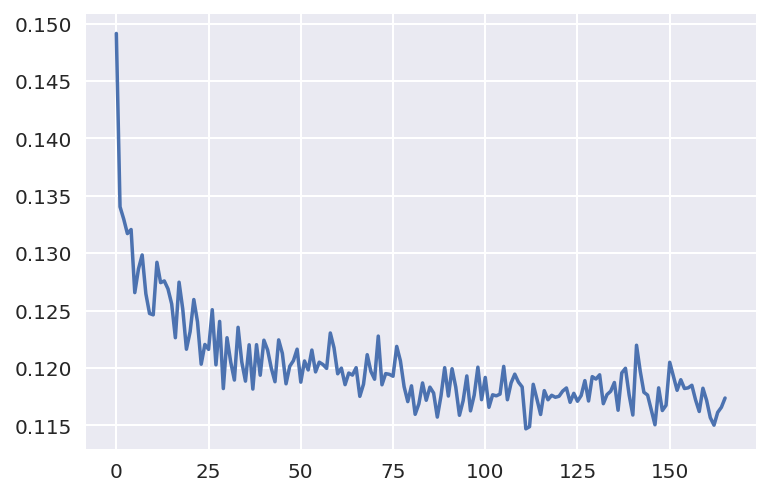

In [106]:
train_losses = pd.Series(train_losses)
train_losses.plot()

In [107]:
torch.save(model.state_dict(), NEURALNET/'AllTrain_FinalNet.pkl')

In [108]:
from src.structured_lstm import get_predictions

In [109]:
targets, preds = get_predictions(model, test_dl, USE_CUDA=True)

[0/484758 (0%)]
[153600/484758 (32%)]
[307200/484758 (63%)]
[460800/484758 (95%)]


In [110]:
test[target_col] = preds

In [115]:
len(test), len(preds), len(targets)

(484758, 484758, 484758)

In [113]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.041435
1,c2cc6cc2a8,0.046257
2,a8e94f6344,0.002685
3,758bae1e35,0.000578
4,02ab378ee8,0.001583


In [111]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

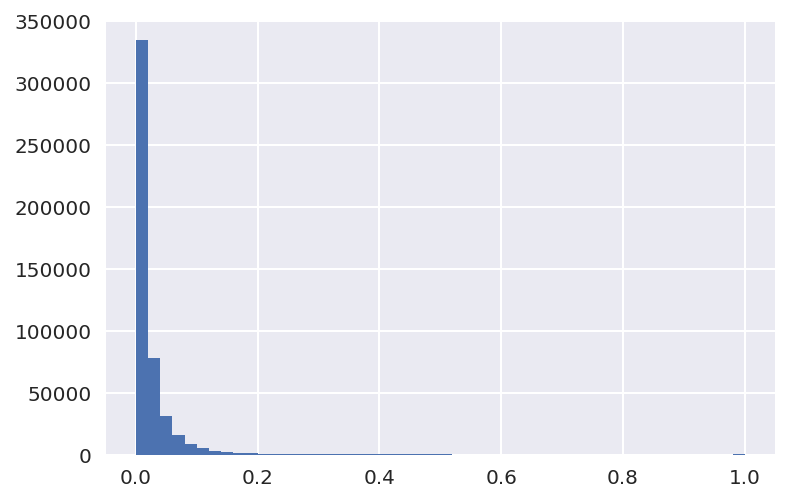

In [112]:
submission[target_col].hist(bins=50)

In [114]:
submission.to_csv(SUBMISSIONS/'RA07-30-FinalStructuredLSTM_2018.csv', index=False)